<a href="https://colab.research.google.com/github/ctugulan/PhD_Projects/blob/main/sea_ice_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # SAM Sea-Ice Orthorectification & Segmentation Demo
---------------------------------------------------------

- Loads a raw image
- Orthorectifies it with intrinsic/​extrinsic parameters
- Sets up GPU / PyTorch / Segment-Anything (SAM)
- 1) Runs SAM automatic mask generation (tunables exposed)
- 2) Builds point-prompts with k-means + distance-transform and re-runs SAM
- Utility helpers: image display, mask overlay, area histogram


In [1]:
# ──────────────────────────────────────────────────────────
#  0. House-keeping — install / import
# ──────────────────────────────────────────────────────────
import sys, subprocess, importlib, os, pathlib, urllib.request, tarfile, shutil, json
import numpy as np
import matplotlib.pyplot as plt
import cv2, torch, scipy


def _pip_install(pkg):
    if importlib.util.find_spec(pkg) is None:
        print(f"⏳ Installing {pkg} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# core deps
for p in ["opencv-python", "scikit-image",
          "matplotlib", "tqdm"]:
    _pip_install(p)

# # cameratransform (for orthorectification)
_pip_install("cameratransform")

⏳ Installing opencv-python …
⏳ Installing scikit-image …


In [2]:
# check GPU access
!nvidia-smi
HOME = os.getcwd()

# Install SAM and torch
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    ## Segment-Anything (direct from GitHub)
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !mkdir {HOME}/weights
    %cd {HOME}/weights

    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# SAM model settings
DEVICE        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE    = "vit_h"
CKPT_FOLDER   = "/content/weights"
CKPT_NAME     = "sam_vit_h_4b8939.pth"
CKPT_PATH     = os.path.join(CKPT_FOLDER, CKPT_NAME)
print(CKPT_PATH, "; exist:", os.path.isfile(CKPT_PATH))

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cameratransform as ct
from scipy.ndimage import distance_transform_edt
from skimage.morphology import dilation, disk
from skimage.feature import peak_local_max
from skimage.measure import regionprops_table


#------------------------------------------
# mount Google Drive
from google.colab import drive

# Explicitly unmount first to clear any previous state
try:
    drive.flush_and_unmount()
    print('Unmounted previous drive instance.')
except ValueError:
    # Ignore if drive was not mounted
    pass

# Attempt to mount the drive again
drive.mount('/content/drive')
#------------------------------------------

print("✅ Environment ready:")

Mon Jun  9 16:03:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# ──────────────────────────────────────────────────────────
#  1. Paths & camera parameters
# ──────────────────────────────────────────────────────────
DIR_PATH = '/content/drive/MyDrive/sea-ice-data/2017-07-04'
IMAGE_NAME = '17-07-04 10-00-53.bmp'
IMAGE_PATH = os.path.join(DIR_PATH, IMAGE_NAME)

# Intrinsics (px)
fx, fy = 1453.86, 1448.71
cx, cy = 1234.44, 1011.30

# Extrinsics
elev_m, tilt_deg, roll_deg = 24, 75, 5

# Orthorectified grid extents (metres) & resolution
ORTHO_EXTENT   = [-65, 46, 20, 85]   # xmin, xmax, ymin, ymax
ORTHO_SCALING  = 0.05                # metres / pixel  (=> 1 px = 5 cm)

In [4]:
# ──────────────────────────────────────────────────────────
#  2. Helper utilities
# ──────────────────────────────────────────────────────────
def display_image(img, title="", ax=None):
    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.gca()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis("off")
    return ax

In [5]:
# ──────────────────────────────────────────────────────────
#  3. Orthorectification
# ──────────────────────────────────────────────────────────
def orthorectify(img_bgr,
                 fx, fy, cx, cy,
                 elev_m, tilt_deg, roll_deg,
                 extent, scale):
    """Return orthorectified top-view image."""
    proj = ct.RectilinearProjection(focallength_x_px=fx,
                                    focallength_y_px=fy,
                                    center_x_px=cx,
                                    center_y_px=cy,
                                    image=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    orient = ct.SpatialOrientation(elevation_m=elev_m,
                                   tilt_deg=tilt_deg,
                                   roll_deg=roll_deg)
    cam = ct.Camera(proj, orient)
    top = cam.getTopViewOfImage(image=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB),
                                extent=extent,
                                scaling=scale,
                                do_plot=False)
    return cv2.cvtColor(top, cv2.COLOR_RGB2BGR)


In [6]:
# ──────────────────────────────────────────────────────────
#  4. Mask generation helpers
# ──────────────────────────────────────────────────────────
def get_sam_model(device=DEVICE):
    # download weights once
    os.makedirs(CKPT_FOLDER, exist_ok=True)
    # if not os.path.isfile(CKPT_PATH):
    #     print("⏳ Downloading SAM weights (~2 GB)…")
    #     url = f"https://dl.fbaipublicfiles.com/segment_anything/{CKPT_NAME}"
    #     urllib.request.urlretrieve(url, CKPT_PATH)
    SAM = sam_model_registry[MODEL_TYPE](checkpoint=CKPT_PATH)
    SAM.to(device=DEVICE)
    return SAM

def automatic_masks(img_rgb, SAM, **generator_kwargs):
    gen = SamAutomaticMaskGenerator(SAM, **generator_kwargs)
    return gen.generate(img_rgb)

def overlay_masks(img_rgb, masks, alpha=0.35, max_area=None):
    """Overlay list-of-dict masks (SAM format) on an RGB image."""
    if not masks:
        return img_rgb
    # sort by area – largest first
    m_sorted = sorted(masks, key=lambda m: m["area"], reverse=True)
    H, W = img_rgb.shape[:2]
    overlay = np.zeros((H, W, 4), dtype=np.float32)
    colormap = plt.cm.viridis
    if max_area is None:
        max_area = m_sorted[0]["area"]
    for m in m_sorted:
        rel = m["area"] / max_area
        color = list(colormap(rel)[:3]) + [alpha]
        overlay[m["segmentation"]] = color
    out = img_rgb.copy()
    out = cv2.cvtColor(out, cv2.COLOR_BGR2BGRA) / 255.0
    out[overlay[...,3]>0] = overlay[overlay[...,3]>0]
    return (out*255).astype(np.uint8)


In [7]:
def plot_area_histogram(mask_dicts, cutoff=None, bins=20):
    areas = [m["area"] for m in mask_dicts]
    if cutoff:
        areas = [a for a in areas if a <= cutoff]
    # Use plt.subplots() to get both the figure and axes objects
    fig, ax = plt.subplots(figsize=(6,4))
    n, bins, patches = ax.hist(areas, bins=bins) # Plot the histogram on the captured axes
    norm = plt.Normalize(min(bins), max(bins))
    for b, p in zip(0.5*(bins[:-1]+bins[1:]), patches):
        p.set_facecolor(plt.cm.viridis(norm(b)))
    # Pass the axes object to colorbar
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="viridis"),
                 label="Mask area (px²)", ax=ax)
    ax.set_xlabel("Mask area (px²)") # Use the ax object to set labels and title
    ax.set_ylabel("Frequency")
    ax.set_title("Floe size distribution")
    plt.show()

<Axes: title={'center': 'Orthorectified'}>

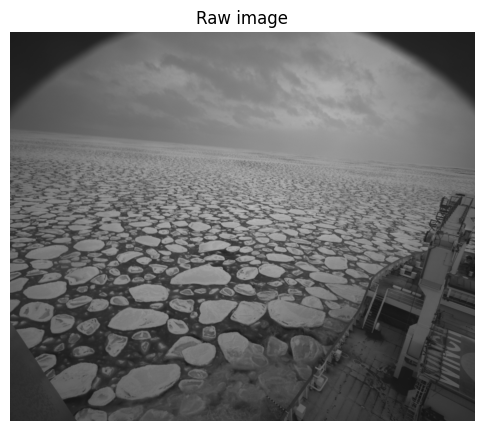

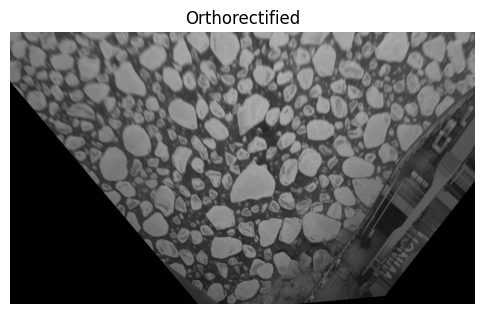

In [8]:
# ──────────────────────────────────────────────────────────
#  5. Main routine
# ──────────────────────────────────────────────────────────
# 1. Load raw image
raw_bgr = cv2.imread(IMAGE_PATH)
if raw_bgr is None:
    raise FileNotFoundError(f"Cannot read image: {IMAGE_PATH}")
display_image(raw_bgr, "Raw image")

# 2. Orthorectify
ortho_bgr = orthorectify(raw_bgr, fx, fy, cx, cy,
                          elev_m, tilt_deg, roll_deg,
                          ORTHO_EXTENT, ORTHO_SCALING)
display_image(ortho_bgr, "Orthorectified")


In [9]:
# automatic-mask generator defaults
AUTO_CFG = dict(
    points_per_side           = 32,
    pred_iou_thresh           = 0.5,
    stability_score_thresh    = 0.95,
    crop_n_layers             = 2,
    crop_n_points_downscale_factor = 2,
    min_mask_region_area      = 100,   # needs OpenCV
)

def automain(ortho_bgr):
    # 3. SAM setup
    SAM = get_sam_model()

    # 4-A. Automatic mask gen
    auto_masks = automatic_masks(cv2.cvtColor(ortho_bgr, cv2.COLOR_BGR2RGB),
                                 SAM, **AUTO_CFG)
    print(f"Automatic masks generated: {len(auto_masks)}")
    overlay = overlay_masks(cv2.cvtColor(ortho_bgr, cv2.COLOR_BGR2RGB),
                            auto_masks)
    display_image(cv2.cvtColor(overlay, cv2.COLOR_BGRA2BGR),
                  f"Automatic masks ({len(auto_masks)})")
    return auto_masks

Automatic masks generated: 510


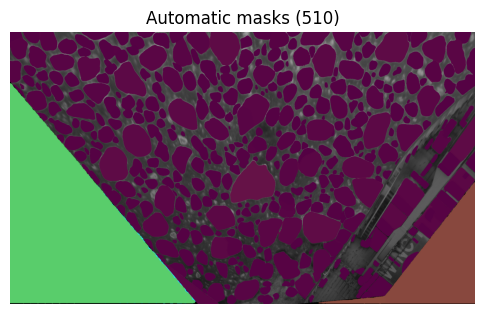

In [12]:
auto_masks = automain(ortho_bgr)


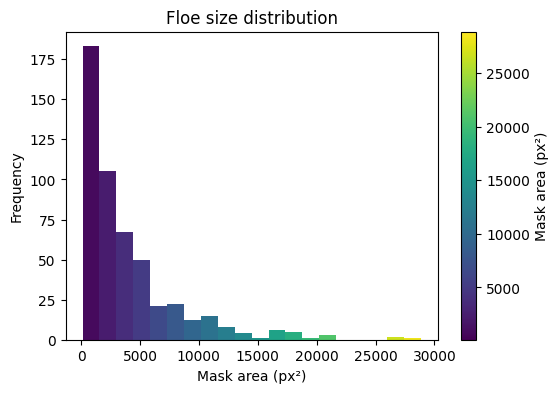

In [13]:
plot_area_histogram(auto_masks, cutoff=100_000)

In [14]:
def build_prompt_points(img_gray, k=3, min_dist=10, dilate_radius=15):
    """
    k-means on non-black pixels (k classes) ➜ distance-transform ➜ local maxima.
    Returns (N,2) coords & labels (all 1s).
    """
    # mask background
    mask = img_gray > 0 # create mask for non-black pixels
    # Apply the boolean mask to img_gray to get only the non-black pixels
    px = img_gray[mask].reshape(-1,1).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(px, k, None, criteria, 10,
                                    cv2.KMEANS_RANDOM_CENTERS)
    clustered = np.zeros_like(img_gray)
    clustered[mask] = centers[labels.flatten(), 0].astype(np.uint8)
    # The display_image utility function expects BGR or RGB,
    # convert the grayscale 'clustered' image to BGR before displaying
    display_image(cv2.cvtColor(clustered, cv2.COLOR_GRAY2BGR),
                  "Clustered image")

    # binary by Otsu on clustered image
    _, binary = cv2.threshold(clustered, 0, 255,
                              cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    dist = distance_transform_edt(binary)
    local_max = peak_local_max(dist, min_distance=min_dist,
                               threshold_abs=0)
    # optionally dilate maxima, then connected-components
    max_img = np.zeros_like(img_gray, dtype=bool)
    max_img[tuple(local_max.T)] = True
    dilated = dilation(max_img, disk(dilate_radius))
    _, lbl = cv2.connectedComponents(dilated.astype(np.uint8))
    props = regionprops_table(lbl, properties=["centroid"])
    pts = np.column_stack((props["centroid-1"], props["centroid-0"]))  # x,y
    return pts.astype(np.int32), np.ones(len(pts), dtype=int)

def masks_from_points(img_rgb, sam, points, labels):
    predictor = SamPredictor(sam)
    predictor.set_image(img_rgb)
    masks, scores, _ = predictor.predict(point_coords=points,
                                         point_labels=labels,
                                         multimask_output=False)
    return masks[0] if isinstance(masks, np.ndarray) else masks

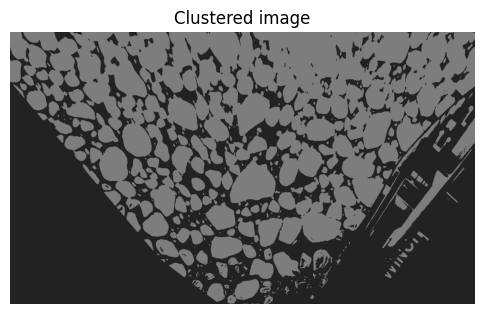

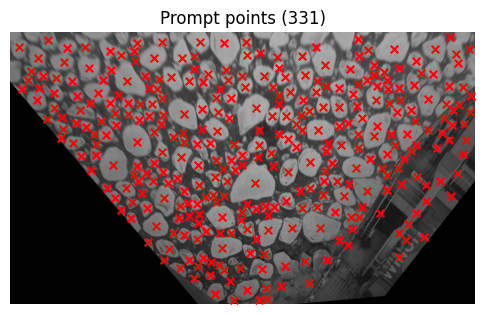

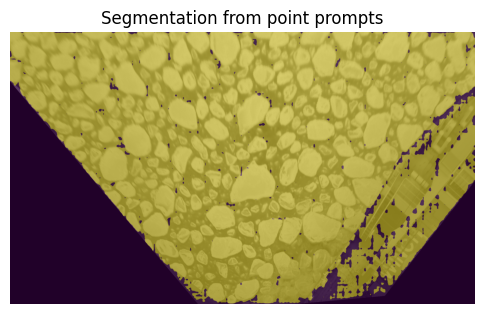

In [15]:
# @title


def promptseg(ortho_bgr):


    # 4-B. Point-prompt masks via k-means + distance-transform
    img_gray = cv2.cvtColor(ortho_bgr, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (0,0), sigmaX=1.0)

    pts, lbls = build_prompt_points(
    img_blur,
    k=2,             # grains vs background
    min_dist=14,     # ~40% median grain diam.
    dilate_radius=18 # groups peaks inside one grain
)

    # pts, lbls = build_prompt_points(img_gray, k=3)
    # visualise points
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(ortho_bgr, cv2.COLOR_BGR2RGB))
    plt.scatter(pts[:,0], pts[:,1], c="red", s=30, marker="x")
    plt.title(f"Prompt points ({len(pts)})")
    plt.axis("off"); plt.show()

    SAM = get_sam_model()
    mask_pt = masks_from_points(cv2.cvtColor(ortho_bgr, cv2.COLOR_BGR2RGB),
                                SAM, pts, lbls)
    # show
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(cv2.cvtColor(ortho_bgr, cv2.COLOR_BGR2RGB))
    ax.imshow(mask_pt, alpha=0.5, cmap="viridis")
    ax.set_title("Segmentation from point prompts")
    ax.axis("off")
    plt.show()

promptseg(ortho_bgr)

# if __name__ == "__main__":
#     main()